Task 1 – Basic PageRank computation on `pagelinks.txt` with distribution and convergence output.

Highest-rank page: 93.0  (PR=0.02835256)
Lowest-rank  page: 48.0 (PR=0.00150000)


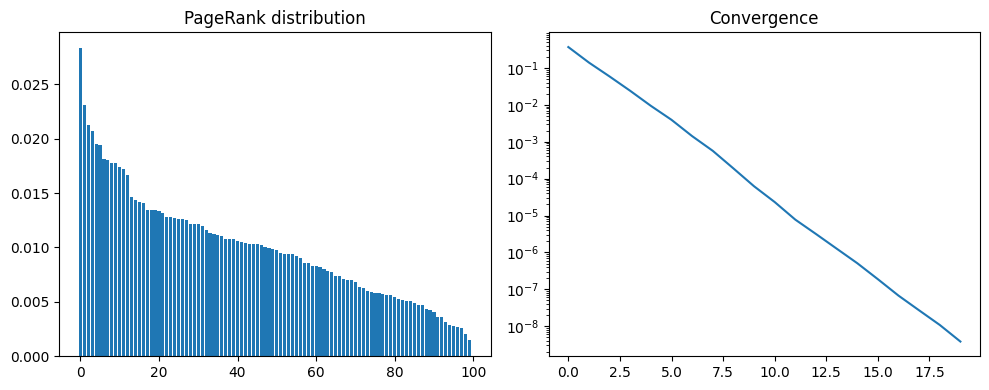

Finished in 0.60s  (20 iterations)


In [ ]:
import time
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

def load_graph(path: str) -> dict[int, list[int]]:
    g = {}
    with open(path, "r") as fh:
        for line in fh:
            if ":" not in line:
                continue
            src, tgt_str = line.strip().split(": ")
            tgt = [int(x) for x in tgt_str.strip("[]").split(",") if x]
            g[int(src)] = tgt
    return g

def build_reverse_index(g: dict[int, list[int]], n=100):
    for v in range(n):
        g.setdefault(v, [])
    inc = defaultdict(list)
    for u, outs in g.items():
        for v in outs:
            inc[v].append(u)
    return inc

def pagerank(g, inc, d=0.85, eps=1e-8, iters=100):
    n = len(g)
    r = {v: 1 / n for v in g}
    hist = []
    for _ in range(iters):
        leak = sum(r[v] for v, outs in g.items() if len(outs) == 0)
        base = (1 - d) / n + d * leak / n
        new_r, diff = {}, 0.0
        for v in g:
            s = sum(r[u] / len(g[u]) for u in inc[v])
            new_r[v] = base + d * s
            diff += abs(new_r[v] - r[v])
        r, hist = new_r, hist + [diff]
        if diff < eps:
            break
    return r, hist

def main(path="pagelinks.txt", d=0.85):
    t0 = time.time()
    g = load_graph(path)
    inc = build_reverse_index(g)
    ranks, history = pagerank(g, inc, d)

    df = pd.DataFrame(sorted(ranks.items(), key=lambda x: x[1], reverse=True),
                      columns=["page", "score"])
    best, worst = df.iloc[0], df.iloc[-1]

    print(f"Highest-rank page: {best['page']}  (PR={best['score']:.8f})")
    print(f"Lowest-rank  page: {worst['page']} (PR={worst['score']:.8f})")

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.bar(df.index, df.score); plt.title("PageRank distribution")

    plt.subplot(1,2,2)
    plt.plot(history); plt.yscale("log"); plt.title("Convergence")

    plt.tight_layout(); plt.show()
    print(f"Finished in {time.time()-t0:.2f}s  ({len(history)} iterations)")

if __name__ == "__main__":
    main()


 TASK 2 - Identify highest and lowest PageRank nodes

In [ ]:
g   = load_graph("pagelinks.txt")
inc = build_reverse_index(g)
ranks, _ = pagerank(g, inc)

high_id, high_score = max(ranks.items(), key=lambda x: x[1])
low_id,  low_score  = min(ranks.items(), key=lambda x: x[1])

print("\n" + "="*40)
print("HIGHEST & LOWEST PAGERANK NODES")
print("="*40)
print(f"Highest PageRank : Page {high_id} | PR = {high_score:.8f}")
print(f"Lowest  PageRank : Page {low_id}  | PR = {low_score:.8f}")



HIGHEST & LOWEST PAGERANK NODES
Highest PageRank : Page 93 | PR = 0.02835256
Lowest  PageRank : Page 48  | PR = 0.00150000


Weighted PageRank – implementation for subtasks 3&4


Weighted PageRank – convergence summary
 damping  iterations final_diff time_s
    0.50          14    5.4e-09   0.00
    0.85          24    5.2e-09   0.01
    0.95          28    6.1e-09   0.01


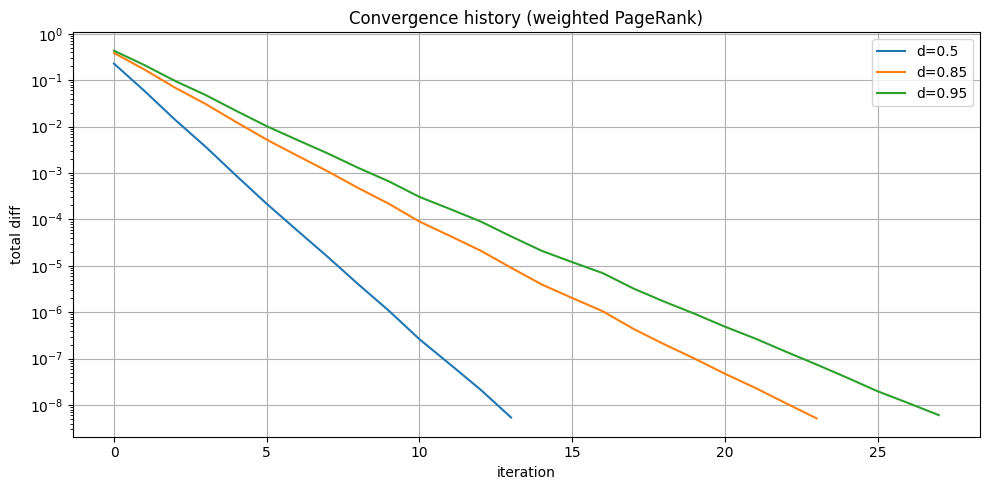

,damping,iterations,final_diff,time_s
0,0.50,14,5.404025e-09,0.003237
1,0.85,24,5.189015e-09,0.005440
2,0.95,28,6.094757e-09,0.011353


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import time

def edge_weights(graph, base_rank, mode="position"):
    """
    Return {(u,v): w_uv} where sum_v w_uv = 1 for every u with outlinks.
    mode = 'position' | 'pagerank' | 'combined'
    """
    ew = {}
    for u, outs in graph.items():
        if not outs:
            continue
        if mode == "position":
            raw = np.arange(len(outs), 0, -1)
        elif mode == "pagerank":
            raw = np.array([base_rank[v] for v in outs])
        else:  # combined: position × target-PR
            raw = np.arange(len(outs), 0, -1) * np.array([base_rank[v] for v in outs])
        raw = raw / raw.sum()
        for v, w in zip(outs, raw):
            ew[(u, v)] = w
    return ew

def weighted_pagerank(graph, ew, d=0.85, eps=1e-8, iters=100):
    n = len(graph)
    r = {v: 1 / n for v in graph}
    inc = build_reverse_index(graph)          # reuse helper
    hist = []
    for _ in range(iters):
        leak = sum(r[v] for v, outs in graph.items() if len(outs) == 0)
        base = (1 - d) / n + d * leak / n
        new_r, diff = {}, 0.0
        for v in graph:
            s = sum(r[u] * ew.get((u, v), 0) for u in inc[v])
            new_r[v] = base + d * s
            diff += abs(new_r[v] - r[v])
        r, hist = new_r, hist + [diff]
        if diff < eps:
            break
    return r, hist

def run_weighted_pr(path="pagelinks.txt",
                    mode="position",
                    factors=(0.50, 0.85, 0.95),
                    eps=1e-8,
                    iters=200):
    g   = load_graph(path)
    inc = build_reverse_index(g)

    base_r, _ = pagerank(g, inc)

    ew = edge_weights(g, base_r, mode=mode)

    results = []
    all_hist = {}

    for d in factors:
        t0 = time.time()
        r, hist = weighted_pagerank(g, ew, d, eps, iters)
        all_hist[d] = hist
        results.append({
            "damping": d,
            "iterations": len(hist),
            "final_diff": hist[-1],
            "time_s": time.time() - t0
        })

    table = pd.DataFrame(results)
    print("\nWeighted PageRank – convergence summary")
    print(table.to_string(index=False, formatters={
        "final_diff": "{:.1e}".format,
        "time_s": "{:.2f}".format}))

    plt.figure(figsize=(10,5))
    for d in factors:
        plt.plot(all_hist[d], label=f"d={d}")
    plt.yscale("log"); plt.xlabel("iteration"); plt.ylabel("total diff")
    plt.title("Convergence history (weighted PageRank)")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

    return table

run_weighted_pr(mode="position")


Task 4 – convergence speed vs. damping factor


Weighted PageRank convergence
 damping  iterations final_diff
    0.50          14   5.40e-09
    0.85          24   5.19e-09
    0.95          28   6.09e-09


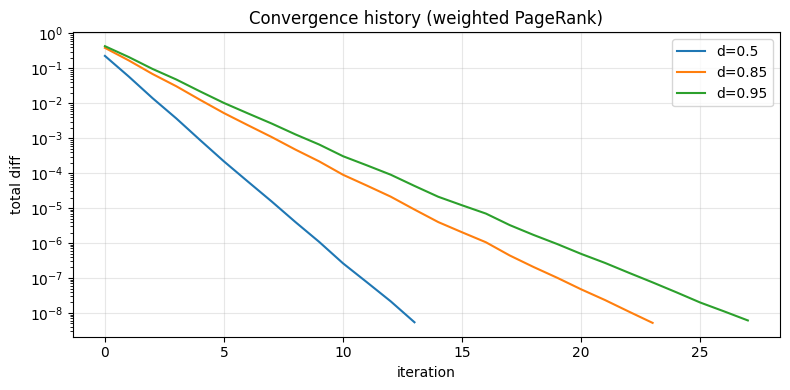

,damping,iterations,final_diff
0,0.50,14,5.404025e-09
1,0.85,24,5.189015e-09
2,0.95,28,6.094757e-09


In [ ]:
def damping_factor_analysis(
        path="pagelinks.txt",
        factors=(0.50, 0.85, 0.95),
        eps=1e-8,
        max_iter=200):

    g   = load_graph(path)
    inc = build_reverse_index(g)

    base_pr, _ = pagerank(g, inc)
    ew = edge_weights(g, base_pr, mode="position")

    rows, curves = [], {}
    for d in factors:
        pr, hist = weighted_pagerank(g, ew, d, eps, max_iter)
        rows.append({"damping": d,
                     "iterations": len(hist),
                     "final_diff": hist[-1]})
        curves[d] = hist

    df = pd.DataFrame(rows)
    print("\nWeighted PageRank convergence")
    print(df.to_string(index=False, formatters={"final_diff": "{:.2e}".format}))

    plt.figure(figsize=(8,4))
    for d in factors:
        plt.plot(curves[d], label=f"d={d}")
    plt.yscale("log"); plt.xlabel("iteration"); plt.ylabel("total diff")
    plt.title("Convergence history (weighted PageRank)")
    plt.legend(); plt.grid(True, alpha=.3); plt.tight_layout(); plt.show()

    return df

damping_factor_analysis()


Task 5 — Finds and plots the five pages with the largest rank swing across damping factors


Most damping-sensitive pages (top 5)
 page  max_diff  rank@0.5  rank@0.85  rank@0.95
   98        28        22         43         50
   75        26        25         45         51
   55        22        49         30         27
    4        19        94         80         75
   49        19        50         33         31


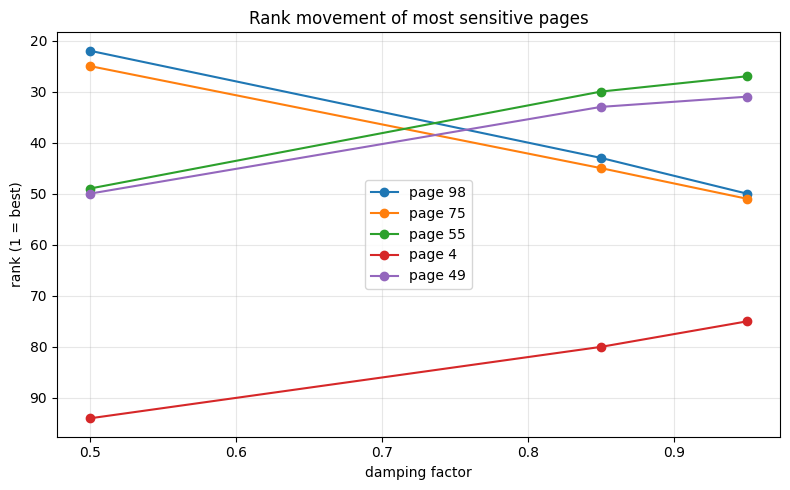

,page,max_diff,rank@0.5,rank@0.85,rank@0.95
0,98,28,22,43,50
1,75,26,25,45,51
2,55,22,49,30,27
3,4,19,94,80,75
4,49,19,50,33,31


In [ ]:
def sensitive_nodes(path="pagelinks.txt",
                    factors=(0.50, 0.85, 0.95),
                    eps=1e-8,
                    iters=200,
                    top_k=5):

    g   = load_graph(path)
    inc = build_reverse_index(g)

    base_pr, _ = pagerank(g, inc)
    ew = edge_weights(g, base_pr, mode="position")

    all_pr = {}
    for d in factors:
        pr, _ = weighted_pagerank(g, ew, d, eps, iters)
        all_pr[d] = pr

    pages = list(g.keys())
    ranks = {d: {p: r for r, (p, _) in enumerate(
                 sorted(all_pr[d].items(), key=lambda x: x[1], reverse=True), 1)}
             for d in factors}

    data = []
    for p in pages:
        rlist = [ranks[d][p] for d in factors]
        data.append({"page": p,
                     "max_diff": max(rlist) - min(rlist),
                     **{f"rank@{d}": ranks[d][p] for d in factors}})
    df = (pd.DataFrame(data)
            .sort_values("max_diff", ascending=False)
            .reset_index(drop=True))

    print("\nMost damping-sensitive pages (top {})".format(top_k))
    print(df.head(top_k).to_string(index=False))

    plt.figure(figsize=(8,5))
    for _, row in df.head(top_k).iterrows():
        y = [row[f"rank@{d}"] for d in factors]
        plt.plot(factors, y, marker="o", label=f"page {row.page}")
    plt.gca().invert_yaxis()
    plt.xlabel("damping factor"); plt.ylabel("rank (1 = best)")
    plt.title("Rank movement of most sensitive pages")
    plt.grid(True, alpha=.3); plt.legend(); plt.tight_layout(); plt.show()

    return df.head(top_k)

sensitive_nodes()


Task 6 — Implements HITS, converges, and prints the top-5 Authority and Hub page

In [ ]:
def hits(graph, inc, eps=1e-8, iters=100):
    pages = list(graph.keys())
    a = {v: 1.0 for v in pages}
    h = {v: 1.0 for v in pages}

    for _ in range(iters):
        # update authority
        new_a = {v: sum(h[u] for u in inc[v]) for v in pages}
        # update hub
        new_h = {v: sum(new_a[w] for w in graph[v]) for v in pages}

        # normalise
        z_a = sum(x*x for x in new_a.values())**0.5 or 1
        z_h = sum(x*x for x in new_h.values())**0.5 or 1
        new_a = {v: x/z_a for v, x in new_a.items()}
        new_h = {v: x/z_h for v, x in new_h.items()}

        if (max(abs(new_a[v]-a[v]) for v in pages) < eps and
            max(abs(new_h[v]-h[v]) for v in pages) < eps):
            break
        a, h = new_a, new_h
    return a, h

def run_hits(path="pagelinks.txt"):
    g   = load_graph(path)
    inc = build_reverse_index(g)

    auth, hub = hits(g, inc)

    topA = sorted(auth.items(), key=lambda x: x[1], reverse=True)[:5]
    topH = sorted(hub.items(),  key=lambda x: x[1], reverse=True)[:5]

    print("\nTop-5 authority pages:")
    for i, (p,s) in enumerate(topA, 1):
        print(f"{i}. page {p}  |  authority = {s:.4f}")

    print("\nTop-5 hub pages:")
    for i, (p,s) in enumerate(topH, 1):
        print(f"{i}. page {p}  |  hub = {s:.4f}")

    return auth, hub

authority_scores, hub_scores = run_hits()



Top-5 authority pages:
1. page 37  |  authority = 0.2014
2. page 41  |  authority = 0.1945
3. page 27  |  authority = 0.1905
4. page 58  |  authority = 0.1870
5. page 2  |  authority = 0.1849

Top-5 hub pages:
1. page 21  |  hub = 0.1851
2. page 98  |  hub = 0.1790
3. page 55  |  hub = 0.1648
4. page 18  |  hub = 0.1632
5. page 85  |  hub = 0.1627


Tasks 7 & 8 – compare PageRank with HITS results



Top-5 PageRank pages : [93, 47, 16, 87, 54]
Top-5 Authority pages: [37, 41, 27, 58, 2]
Top-5 Hub pages      : [21, 98, 55, 18, 85]

Overlap (top-5):
  PageRank ∩ Authority : 0
  PageRank ∩ Hub       : 0

Page 93 shows the largest PR ↔ Authority gap:
  PageRank position : 1
  Authority position: 81
  Rank difference   : 80


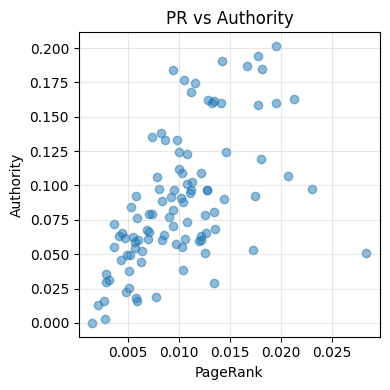

{'pr_top': [93, 47, 16, 87, 54],
 'auth_top': [37, 41, 27, 58, 2],
 'hub_top': [21, 98, 55, 18, 85],
 'worst_gap_page': 93,
 'gap': 80}

In [ ]:
def compare_pr_hits(pr, auth, hub, top_k=5):
    pr_top   = [p for p, _ in sorted(pr.items(),   key=lambda x: x[1], reverse=True)[:top_k]]
    auth_top = [p for p, _ in sorted(auth.items(), key=lambda x: x[1], reverse=True)[:top_k]]
    hub_top  = [p for p, _ in sorted(hub.items(),  key=lambda x: x[1], reverse=True)[:top_k]]

    print("\nTop-{} PageRank pages : {}".format(top_k, pr_top))
    print("Top-{} Authority pages: {}".format(top_k, auth_top))
    print("Top-{} Hub pages      : {}".format(top_k, hub_top))

    pr_auth_overlap = len(set(pr_top) & set(auth_top))
    pr_hub_overlap  = len(set(pr_top) & set(hub_top))

    print("\nOverlap (top-{}):".format(top_k))
    print(f"  PageRank ∩ Authority : {pr_auth_overlap}")
    print(f"  PageRank ∩ Hub       : {pr_hub_overlap}")

    rank_pr   = {p: i+1 for i,(p,_) in enumerate(sorted(pr.items(),   key=lambda x:x[1], reverse=True))}
    rank_auth = {p: i+1 for i,(p,_) in enumerate(sorted(auth.items(), key=lambda x:x[1], reverse=True))}

    worst = max(pr.keys(), key=lambda p: abs(rank_pr[p] - rank_auth[p]))
    diff  = abs(rank_pr[worst] - rank_auth[worst])

    print(f"\nPage {worst} shows the largest PR ↔ Authority gap:")
    print(f"  PageRank position : {rank_pr[worst]}")
    print(f"  Authority position: {rank_auth[worst]}")
    print(f"  Rank difference   : {diff}")

    plt.figure(figsize=(4,4))
    plt.scatter([pr[p] for p in pr], [auth[p] for p in pr], alpha=.5)
    plt.xlabel("PageRank"); plt.ylabel("Authority"); plt.grid(True, alpha=.3)
    plt.title("PR vs Authority"); plt.tight_layout(); plt.show()

    return {"pr_top": pr_top, "auth_top": auth_top,
            "hub_top": hub_top, "worst_gap_page": worst, "gap": diff}

compare_pr_hits(page_ranks, authority_scores, hub_scores)


Tasks 7 & 8 – compare top-5 PageRank with HITS Authority & Hub

In [ ]:
def top_k_overlap(pr, auth, hub, k=5):
    pr_top   = [p for p, _ in sorted(pr.items(),   key=lambda x: x[1], reverse=True)[:k]]
    auth_top = [p for p, _ in sorted(auth.items(), key=lambda x: x[1], reverse=True)[:k]]
    hub_top  = [p for p, _ in sorted(hub.items(),  key=lambda x: x[1], reverse=True)[:k]]

    print(f"Top-{k} PageRank   :", pr_top)
    print(f"Top-{k} Authority  :", auth_top)
    print(f"Top-{k} Hub        :", hub_top)

    print("\nOverlap counts (top-{}):".format(k))
    print("  PageRank ∩ Authority :", len(set(pr_top) & set(auth_top)))
    print("  PageRank ∩ Hub       :", len(set(pr_top) & set(hub_top)))

    r_pr   = {p:i+1 for i,(p,_) in enumerate(sorted(pr.items(),   key=lambda x:x[1], reverse=True))}
    r_auth = {p:i+1 for i,(p,_) in enumerate(sorted(auth.items(), key=lambda x:x[1], reverse=True))}
    gap_page = max(pr.keys(), key=lambda p: abs(r_pr[p] - r_auth[p]))
    gap_size = abs(r_pr[gap_page] - r_auth[gap_page])

    print(f"\nExample for Task 8:")
    print(f"  Page {gap_page} ranks {r_pr[gap_page]} in PageRank but "
          f"{r_auth[gap_page]} in Authority (|Δ|={gap_size}).")

top_k_overlap(page_ranks, authority_scores, hub_scores)


Top-5 PageRank   : [93, 47, 16, 87, 54]
Top-5 Authority  : [37, 41, 27, 58, 2]
Top-5 Hub        : [21, 98, 55, 18, 85]

Overlap counts (top-5):
  PageRank ∩ Authority : 0
  PageRank ∩ Hub       : 0

Example for Task 8:
  Page 93 ranks 1 in PageRank but 81 in Authority (|Δ|=80).
